In [170]:
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import numpy as np

# Load the YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [171]:
def extract_yamnet_embedding(audio_path):
    y, sr = librosa.load(audio_path, sr=16000, mono=True)
    waveform = tf.convert_to_tensor(y, dtype=tf.float32)

    scores, embeddings, spectrogram = yamnet_model(waveform)
    # Use mean of embeddings across time as feature
    embedding_mean = tf.reduce_mean(embeddings, axis=0).numpy()
    return embedding_mean

In [318]:
audios = [
    "output_audios/audio1.wav",
    "output_audios/New recording 21.wav",
    "output_audios/9 Apr, 3.21 pm.wav",
    "splits/teacher1.wav",
    "splits/teacher2.wav",
    "splits/teacher3.wav",
    "splits/teacher4.wav",
    "splits/teacher5.wav",
    "splits/teacher6.wav",
    "splits/teacher7.wav",
    "splits/teacher8.wav",
    "splits/teacher9.wav",
    "splits/student.wav",
    "splits/student2.wav",
    "splits/student3.wav",
     'output_audios/audio7.wav',
    'output_audios/audio8.wav',
    'output_audios/audio9.wav',
    'output_audios/audio10.wav',
    'output_audios/audio11.wav',
    'output_audios/audio12.wav',
    'output_audios/audio13.wav',
    'output_audios/audio14.wav',
    'output_audios/audio15.wav',
    'output_audios/audio16.wav',
    'output_audios/audio17.wav',
]
X = [extract_yamnet_embedding(audio) for audio in audios]

In [416]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_percentage(vec1, vec2):
    # Ensure both are 2D for sklearn
    vec1 = np.array(vec1).reshape(1, -1)
    vec2 = np.array(vec2).reshape(1, -1)
    similarity = cosine_similarity(vec1, vec2)[0][0]
    return similarity * 100  # Convert to percentage

similarity = cosine_similarity_percentage(X[2], X[3])
print(f"Cosine similarity: {similarity:.2f}%")

Cosine similarity: 70.79%


In [294]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [319]:
X = np.array(X)  # your list of 1024-dim embeddings

# # Scale features (important for DBSCAN with Euclidean distance)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X.shape

(26, 1024)

In [320]:
# --- Step 1: Scale the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.82778686, -0.42186943, -0.5558929 , ...,  0.79062533,
        -0.4704889 , -0.2       ],
       [ 1.5864928 , -1.4209093 , -0.7017459 , ..., -0.4907751 ,
        -0.4704889 , -0.2       ],
       [ 0.113059  , -1.4209093 , -0.9393177 , ...,  0.39700848,
        -0.4704889 , -0.2       ],
       ...,
       [-0.82778686, -0.19841005, -0.94525105, ..., -0.4907751 ,
        -0.4704889 , -0.2       ],
       [-0.54088724,  0.9823295 , -0.7892326 , ..., -0.4907751 ,
        -0.4704889 , -0.2       ],
       [-0.82778686,  1.9116819 ,  0.7204415 , ..., -0.4907751 ,
        -0.4704889 , -0.2       ]], dtype=float32)

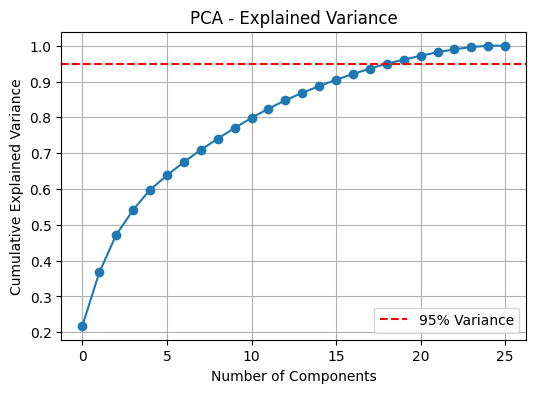

📉 Number of components to retain 95% variance: 20


In [321]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume X_scaled is your scaled (standardized) 1024-dim embeddings
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Get number of components to retain 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"📉 Number of components to retain 95% variance: {n_components_95}")


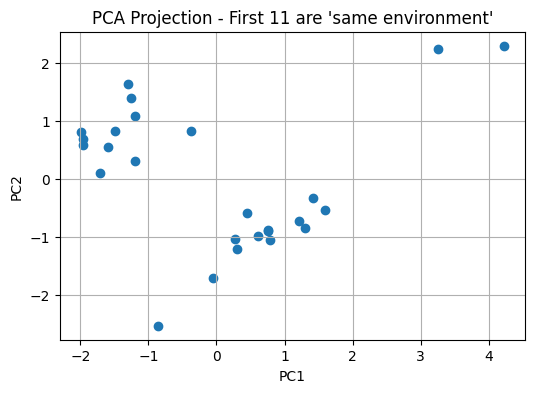

In [344]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize: color first 11 as one group

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title("PCA Projection - First 11 are 'same environment'")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [221]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(X_pca)
# print("Pairwise distances:\n", dists)

First jump ends at index 2, with value 0.11


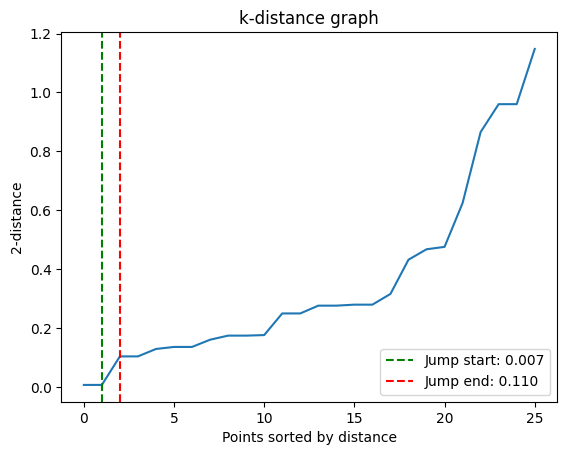

In [369]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import math

# Let's say X_2d is your data after PCA (shape: [n_samples, n_components])
k = 2  # min_samples for DBSCAN (or set to any expected density threshold)

# Step 1: Fit Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)

# Step 2: Calculate distances to the k-th nearest neighbor
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# After you've calculated your sorted distances array
distances_array = np.array(distances)

# Calculate first differences (derivative)
first_diff = np.diff(distances_array)

# Find where the differences become negative (indicating a decrease)
# or very small (indicating flattening)
decreasing_threshold = 0  # For strict decrease
# decreasing_threshold = 0.01 * np.mean(first_diff)  # For near-flattening

# First identify the jump start
jump_threshold = np.mean(first_diff) + 0.5 * np.std(first_diff)
jump_start_indices = np.where(first_diff > jump_threshold)[0]

if len(jump_start_indices) > 0:
    jump_start = jump_start_indices[0]
    
    # Now find where this jump ends (where the slope decreases)
    jump_region = first_diff[jump_start:]
    end_indices = np.where(jump_region <= decreasing_threshold)[0]
    
    if len(end_indices) > 0:
        jump_end = jump_start + end_indices[0]
        jump_end_value = distances_array[jump_end]
        jump_end_value = math.ceil(jump_end_value * 100) / 100 
        print(f"First jump ends at index {jump_end}, with value {jump_end_value}")
    else:
        print("No clear end to the first jump detected")
else:
    print("No significant jump detected")

# Visualize this on your plot
plt.plot(distances_array)
plt.axvline(x=jump_start, color='g', linestyle='--', label=f'Jump start: {distances_array[jump_start]:.3f}')
plt.axvline(x=jump_end, color='r', linestyle='--', label=f'Jump end: {jump_end_value:.3f}')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-distance')
plt.title('k-distance graph')
plt.legend()
plt.show()

In [370]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=jump_end_value,min_samples=3,metric='cosine')
labels = clusterer.fit_predict(X)
labels

array([-1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1])

/tmp/ipykernel_132284/2753246825.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


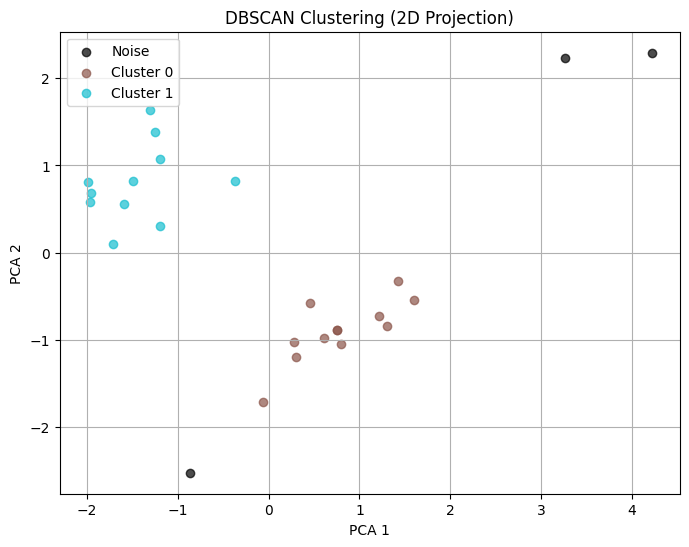

In [371]:
# Step 1: Reduce dimensions to 2D for plotting
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Step 2: Plot
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    # Noise points are usually labeled as -1
    color = 'k' if label == -1 else colors(i)
    plt.scatter(X_2d[labels == label, 0],
                X_2d[labels == label, 1],
                c=[color],
                label=f'Cluster {label}' if label != -1 else 'Noise',
                alpha=0.7)

plt.title('DBSCAN Clustering (2D Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

In [301]:
import hdbscan

# Now cluster on the PCA-reduced data
clusterer = hdbscan.HDBSCAN(min_cluster_size=2,min_samples=1)
labels = clusterer.fit_predict(X)
labels

/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  3,
        3,  3,  3,  3,  2,  2, -1,  3,  3])

Cluster Labels:
[1 0 0 1 0 0 1 1 1 1 1 1 1 1]


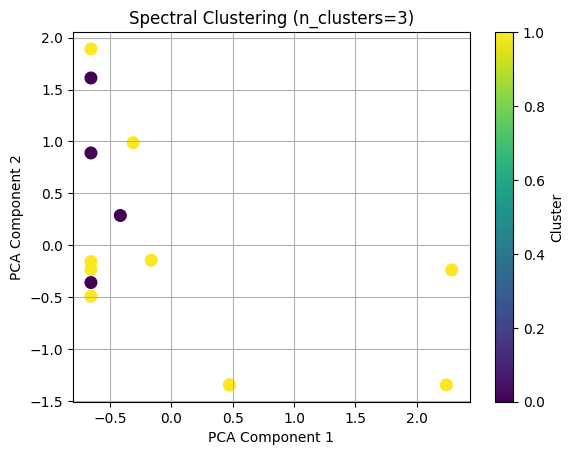

In [169]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Apply Spectral Clustering
spectral = SpectralClustering(
    n_clusters=2,
    affinity='nearest_neighbors',  # builds a KNN graph internally
    random_state=42
)

labels = spectral.fit_predict(X_scaled)

# Step 2: Show the cluster labels
print("Cluster Labels:")
print(labels)

# Step 3: Optional - visualize with PCA (if available)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=70)
plt.title('Spectral Clustering (n_clusters=3)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()